# Image Localization

Cloning Data from github

In [1]:
!git clone https://github.com/ayulockin/synthetic_datasets
%cd synthetic_datasets/MNIST/

### How to unzip ###
# '%' is used before using terminal commands. Here we build dir
# ! => shell command meant to be executed by system command line 
# -q => silently download the files without showing in output
# -d => unzip for file inside target folder
# !unzip -q file to unzip -d tagerted directory name if not exist it will build automatically

!unzip -q MNIST_Converted_Training.zip -d image_dataset/    
!unzip -q MNIST_Converted_Testing.zip -d image_dataset/

Cloning into 'synthetic_datasets'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 42 (delta 1), reused 1 (delta 1), pack-reused 39
Unpacking objects: 100% (42/42), done.
/content/synthetic_datasets/MNIST


In [2]:
#  Come to starting directory
%cd ../..

/content


In [3]:
# check in which directory u are now
%ls

sample_data/  synthetic_datasets/


## Library

In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

## In this dataset we have:
1. Simple Images of digit as MNIST_Converted_Training , MNIST_Converted_Testing.

2. CSV file of test_data, train_data consist of data in tabular form. 
It consist of:
  *   Image Directory name [which we have to modiffy little bit as per our directory saved]
  *   Image class [Eg: 0,1,2...etc]
  *   Bounding Box Coordinates [xmin, ymin, xmax, ymax]
  

In [5]:

S = 'synthetic_datasets'
M = 'MNIST'
I = 'image_dataset'
columns_df = ['path', 'class', 'xmin', 'ymin', 'xmax', 'ymax']


### reading Train data ###

#reading csv file by passing its path location
train_df = pd.read_csv(os.path.join(S,M, 'training_data.csv'), header=None)
# giving column names to the train_df
train_df.columns = columns_df


### reading Test data ###

#reading csv file by passing its path location
test_df = pd.read_csv(os.path.join(S,M, 'test_data.csv'), header=None)
# giving column names to the train_df
test_df.columns = columns_df


### Manipulation in path ###

# Path of the images in traind_df and test_df is still not completly correct if we want to access the
# image we have to struggle little bit hence adding more specific path prior to the mentioned path
t = 'MNIST_Converted_Training'
train_df['path'] = train_df['path'].apply(lambda s: os.path.join(S, M, I, t, s))

t = 'MNIST_Converted_Testing'
test_df['path'] = test_df['path'].apply(lambda s: os.path.join(S, M, I, t, s))




## Playing around in small scale then apply to prediction state

- w'll use these two function in prediction state.


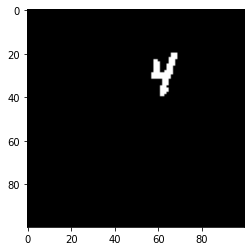

In [6]:

def load_img_vis(input_img):

  # input_img = train_df['path'].iloc[0]

  #reads the image using tf.io it just simply returns file as it is
  image = tf.io.read_file(input_img)  

  # image we got from previous step is the image in our dataset which is .png format now decoding it
  image = tf.image.decode_png(image, channels=1)

  # image channel was 1(gray scale) converting it to 3(bgr) AS matplot does accepts dim(x,y,1)
  image = tf.image.grayscale_to_rgb(image)

  # tycasting of image dtype from uint8 to float32
  image = tf.cast(image,tf.float32)

  return image

# calling function and plotting the image
plt.imshow(load_img_vis(train_df['path'].iloc[0]))

In [7]:
row = train_df.iloc[0][2:]
row

xmin    0.49
ymin    0.15
xmax    0.77
ymax    0.43
Name: 0, dtype: object

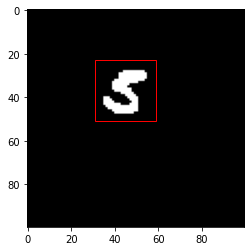

In [8]:

def add_bbox_on_img(df,index):


  # multiply all bbox cordinates with 100 to to make it int  
  x1, y1, x2, y2 = [int(cord*100) for cord in df.iloc[index][2:]] 
  
  width = x2 - x1
  height = y2 - y1

  # build rectangular patch
  rectangle = plt.Rectangle((x1,y1), width, height, fill = False, linewidth=1, edgecolor='r')

  # plot patch
  img = load_img_vis(df['path'].iloc[index])
  fig, ax = plt.subplots()
  ax.imshow(img)
  # finally plotting patch
  ax.add_patch(rectangle)
  plt.show()



add_bbox_on_img(train_df,205)

## Model Building:
*   applying transfer learning using the base model as EfficientNet.
*   Importing keras efficientNet.




In [22]:

# Build base CNN layer EfficientNet using Keras
def build_cnn_layer():
  
  # using keras.EfficientNet 
  model = tf.keras.applications.efficientnet_v2.EfficientNetV2M( 
      include_top=False,
      weights='imagenet',
      input_shape=(100,100,3)   )

  # except last 5 layers freeze all the layers for training
  for i in model.layers[:-5]:
    i.trainable = False
  
  return model





# Build Dense layers
def build_dense_layers(input_image):

  x = input_image
  x = layers.Flatten()(x)  #Flattening of input image matrix into vector for ANN
  x = layers.Dense(128, activation = 'relu')(x)
  # x = layers.Dense(128, activation = 'relu')(x)

  return x





# Build classification head layer
def build_classifier_head(input_image):

  x = input_image 
  # for multi class very important to give name to head layers[class & regress], with thier name only we assign loss while compiling.
  classifier_head = layers.Dense(10, activation = 'softmax', name = 'class')(x)   # have classify only 10 classes

  return classifier_head





# Build regressor head layer
def build_regressor_head(input_image):
  
  x = input_image
  regressor_head = layers.Dense(4, name = 'regressor' )(x)   # have 4 bounding box location to predict 

  return regressor_head


# base_model = build_base_layer(tf)



**Combining all the seperate layer we built in the seperate functions**

In [25]:
from numpy.ma.core import shape

# Combining whole architect:   [USING FUNCTIONAL API]

def final_model():

  image_input = tf.keras.Input(shape=(100,100,3))  # passing input shape necessary in functional API

  #adding cnn layer
  base_model = build_cnn_layer() #build varaible to store the function returned value
  x = base_model(image_input)  #input the data in base_model using functional API mtd

  # adding dense layer
  x = build_dense_layers(x)

### Two Output heads needs the same input x from the dense layer ###

  #adding classif head
  classif_head = build_classifier_head(x)

  #adding regressor head
  regress_head = build_regressor_head(x)


  # multi-output hence passing list of output heads in output parameter
  return  tf.keras.Model(inputs= image_input, outputs= [classif_head, regress_head])




## Arranging Image data to pass for model training:
 - We have image path in train_df & test_df.
 - So to give the image to the model we first have to take the image from the path we cannot dirctly give the path to the model bcz model accepts image as tensor/matrix not the string of path.
 - Hence w'll create load_image() function.
 - the above function will read the path -> decode it -> convert the channel -> change value dtype from uint8 to float.
 - Also we have to create tensorflow dataset to store all this Image(not path) + class + bbox locations **bcz model accepts tensorflow dataset not .csv file**

In [132]:


columns_df = ['xmin', 'ymin', 'xmax', 'ymax']

# converting all df_train columns into individual arrays and passing it to form tensorflow dataset
# train_path_arr = np.array(train_df['path'])
train_class_arr = np.array(train_df['class'])
train_bbox_arr = np.array(train_df[columns_df])

# converting all df_test columns into individual arrays and passing it to form tensorflow dataset
# test_path_arr = np.array(test_df['path'])
test_class_arr = np.array(test_df['class'])
test_bbox_arr = np.array(test_df[columns_df])


#### NOTE: ####
#1. from_tensor_slices is used to build tensorflow dataset bcz we cannot pass train_df as dataset to model bcz it is in .csv
#2. we need to pass two parameter to from_tensor_slice as bcz load_image fuinction takes two argumen(image path & lables)
#3. Although labels should be just class name but we are now solving Multi-lassification problem [class & regression]
#4. Make sure in tensorflow dataset for multi-class u pass the dictonary key name same as two head layers name bcz this will
#   help during compiling the model while passing the trainind and testing dataset.

train_dataset = tf.data.Dataset.from_tensor_slices((train_df['path'].tolist(), 
                                                     {"class":train_class_arr, "regressor":train_bbox_arr}) )
 

# from_tensor_slices is used to build tensorflow dtype dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['path'].tolist(), 
                                                    {"class":test_class_arr, "regressor":test_bbox_arr}) )


# process of getting the image through the path and return image as matrix & lable dict of {class, regressor} as it is
def load_image(path, label):

  # read the file from the path
  image = tf.io.read_file(path)

  #now to decode the file from previous readfile because it read the file and stored it in Machine language now we have to decode it 
  image = tf.image.decode_png(image, channels=1)
  
  # # convert the channels from 1 to 3 bcz model accepts 3 channel
  image = tf.image.grayscale_to_rgb(image)

  image = tf.cast(image, dtype=tf.float32) / 255. #after typecast do normalize also

  # image = tf.expand_dims(image, axis=0)
  # image = tf.expand_dims(image, axis=0)
  return image, label


# Now to successfully replace the train_df path containing part with actuall image matrix as well as with dictonary
# of class and regresso value, all this inside tensorflow dataset.

# using map() with tensorflow dataset [tf_Dataset.map(func)]  --> tf_dataset is like iterable ---> see documentation
train_dataset = train_dataset.map(load_image).batch(30)  #randomly assigned batch size, 

test_dataset = test_dataset.map(load_image).batch(30)   #randomly assigned batch size


#### For understanding try run this loop what's inside train_dataset ####
# for i in train_dataset:
#   print(i)



## Model Compilation:
 - w'll use tensorflow compile method which is a function of tf.keras.model.
 - **we won't be using a custom loops for training the model. custom loop give as more flexibilty in our code for training the model watch https://www.youtube.com/watch?v=q7ZuZ8ZOErE**


In [37]:
# calling the final_model()
model = final_model()

model.summary()  #checking if everything is okay 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetv2-m (Functional)  (None, 4, 4, 1280)   53150388    ['input_6[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 20480)        0           ['efficientnetv2-m[0][0]']       
                                                                                                  
 dense_2 (Dense)                (None, 128)          2621568     ['flatten_2[0][0]']        

In [ ]:
#compile

model.compile( optimizer = 'adam',
              loss = {'class':tf.keras.losses.SparseCategoricalCrossentropy(), 'regressor': tf.keras.losses.MeanSquaredError()},
              metrics = {'class':['accuracy'], 'regressor': ['mse']} )

model.summary()

model.fit(train_dataset, validation_data= test_dataset, batch_size=30, epochs = 4)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetv2-m (Functional)  (None, 4, 4, 1280)   53150388    ['input_6[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 20480)        0           ['efficientnetv2-m[0][0]']       
                                                                                                  
 dense_2 (Dense)                (None, 128)          2621568     ['flatten_2[0][0]']        

## Save Model and Load model

In [44]:
# save model
# model.save('CNN_04_model')

# load model back
model = tf.keras.models.load_model('CNN_04_model')



## Prediction

In [109]:
def load_img_vis(input_img):

  # input_img = train_df['path'].iloc[0]

  #reads the image using tf.io it just simply returns file as it is
  image = tf.io.read_file(input_img)  

  # image we got from previous step is the image in our dataset which is .png format now decoding it
  image = tf.image.decode_png(image, channels=1)

  # image channel was 1(gray scale) converting it to 3(bgr) AS matplot does accepts dim(x,y,1)
  image = tf.image.grayscale_to_rgb(image)

  # tycasting of image dtype from uint8 to float32
  image = tf.cast(image,tf.float32)

  
  image = tf.expand_dims(image, axis=0)

  return image





(1, 100, 100, 3)
(100, 100, 3)


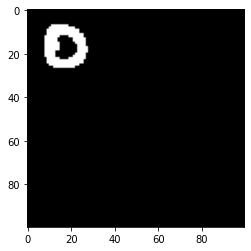

In [112]:
# calling the load_img_vis() to get the image from test data and passing for prediction
img = load_img_vis(test_df['path'].iloc[1])
print(img.shape)

fig, ax = plt.subplots()
img = tf.squeeze(img, axis=0)
print(img.shape)
ax.imshow(img)


In [104]:

def prediction(img):
  
  # model.predict it return array of image_class[10] + regression[4] for each inserted image
  predict = model.predict(img)


  # predicted class of image
  class_predict = np.argmax(predict[0][0].tolist())  #max probability class
  print('max probability class:', class_predict)


  # predicted bbox location of image
  reg_predict = predict[1][0].tolist()
  print('bbox coordinates:', reg_predict)

  return class_predict, reg_predict



1/1 [==============================] - 0s 46ms/step
max probability class: 1
bbox coordinates: [0.3550005555152893, 0.3625701665878296, 0.634964644908905, 0.6424840688705444]


1/1 [==============================] - 0s 77ms/step


max probability class: 1
bbox coordinates: [0.3550005555152893, 0.3625701665878296, 0.634964644908905, 0.6424840688705444]


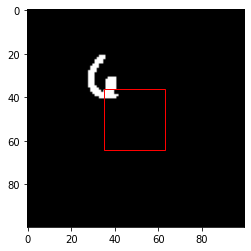

In [131]:
def add_bbox_on_img(df,index):

  # calling the load_img_vis() to get the image from test data and passing for prediction
  img = load_img_vis(df['path'].iloc[index])

  # calling prediction() to use its value here for plotting image with bbox
  class_predict, reg_predict = prediction(img)


  # multiply all bbox cordinates with 100 to to make it int  
  x1, y1, x2, y2 = [int(cord*100) for cord in reg_predict] 
  
  width = x2 - x1
  height = y2 - y1

  # build rectangular patch
  rectangle = plt.Rectangle((x1,y1), width, height, fill = False, linewidth=1, edgecolor='r')

  # plot patch
  img = tf.squeeze(img, axis=0) #reducing dimension if image from 4 to 3 bcz plt accepts 3 dim
  fig, ax = plt.subplots()
  ax.imshow(img)
  # finally plotting patch
  ax.add_patch(rectangle)
  plt.show()



add_bbox_on_img(train_df, 5972)

